Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing.image import load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2245
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:<br>
Batch size refers to the number of training examples utilised in one iteration. The model decides the number of examples to work with in each iteration before updating the internal model parameters.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.<br>
tf.keras.preprocessing.image_dataset_from_directory generates a tf.data.Dataset from image files in a directory.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2245 files belonging to 9 classes.
Using 1796 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2245 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

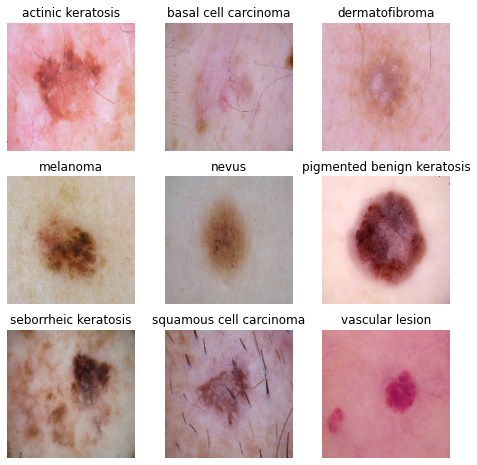

In [10]:
### your code goes here, you can use training or validation data to visualize
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(8,8))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]` <br><br>
The model is given as `sequential`, which means that the layers are set up one after the other in a singular sequence <br><br>
Neural networks that are usually large, complex models with tens of thousands of parameters have a tendency to overfit the training data. As with many other ML models, regularisation is a common technique used in neural networks to address this problem. Let's now take a look at a `popular regularisation technique used for neural networks called dropouts`. <br><br>
It is generally a good idea to have your data on a common scale while training a neural network. Sometimes, when training a neural network, large activations might be produced. Different sizes of activations can result in unstable training behaviour. This is where ‘normalisation’ can be helpful. Normalisation is seen as an aid to the optimisation process. `Commonly seen benefits are that fewer epochs are required to complete the network’s training process and sometimes, it avoids the neural network to get stuck during the training process`

In [12]:
### Your code goes here

model = Sequential()
model.add(Rescaling(scale=1./255,input_shape=(180,180,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(8192,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(512,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training.
After we have defined the model, we need to compile the model. During this step, Keras uses the backend libraries to efficiently represent the above-described model for training and prediction. We need to specify the loss function, the metrics as well as the optimiser in this step

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

A model summary states the details of the parameters used and displays the layers of the architecture.
 the summary shows the total of trainable and non-trainable parameters. Trainable parameters are the ones going through the learning process, i.e., the weights and biases. 
 Non-trainable parameters are the ones that do not go through the training process. 
 For example in the following code, ‘0.15’ defines the number of randomly selected weights set to zero, and this is not going to change throughout the training process.

In [14]:
# View the summary of all layers 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0

### Train the model
The number of epochs mentioned in the code snippet defines the number of times the learning algorithm will work through the entire data set. One epoch indicates that each training example has had an opportunity to update the internal model parameters, i.e., the weights and biases.

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  shuffle=False,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 291s 1s/step - loss: 11.3582 - accuracy: 0.2712 - val_loss: 2.4389 - val_accuracy: 0.1492
Epoch 2/20
57/57 [==============================] - 8s 137ms/step - loss: 1.6736 - accuracy: 0.4154 - val_loss: 8.9769 - val_accuracy: 0.1492
Epoch 3/20
57/57 [==============================] - 8s 137ms/step - loss: 1.4614 - accuracy: 0.4939 - val_loss: 23.3022 - val_accuracy: 0.1492
Epoch 4/20
57/57 [==============================] - 8s 137ms/step - loss: 1.3138 - accuracy: 0.5490 - val_loss: 7.9449 - val_accuracy: 0.1604
Epoch 5/20
57/57 [==============================] - 8s 137ms/step - loss: 1.2797 - accuracy: 0.5713 - val_loss: 23.2855 - val_accuracy: 0.1492
Epoch 6/20
57/57 [==============================] - 8s 138ms/step - loss: 1.1899 - accuracy: 0.5980 - val_loss: 28.9846 - val_accuracy: 0.1514
Epoch 7/20
57/57 [==============================] - 8s 138ms/step - loss: 1.1452 - accuracy: 0.6258 - val_loss: 10.4212 - val_accuracy: 0.2027
Ep

`The text above can be analysed as follows:` 

The text 57/57 indicates the number of batches the training step is running 
through. Since the batch size is 32 and the training data set is of size 1796 (80% of the total  dataset) while the rest 20% is validation dataset.

You can also see the amount of time it is taking for training a single batch, for example, 8s/step.

The text snippets loss and val_loss show the sparse categorical cross-entropy loss (mentioned while compiling the model).

The text snippets accuracy and val_accuracy show the proportion of matches between the predicted class and the actual class. This proportion is calculated on the whole training and validation data sets.

And, after 20 epochs (20 run-throughs of training the whole data set), we can see the validation accuracy reached.

Note: The calculation speed, loss, and accuracy may differ slightly in each runtime as it depends on computational power.




### Visualizing training results

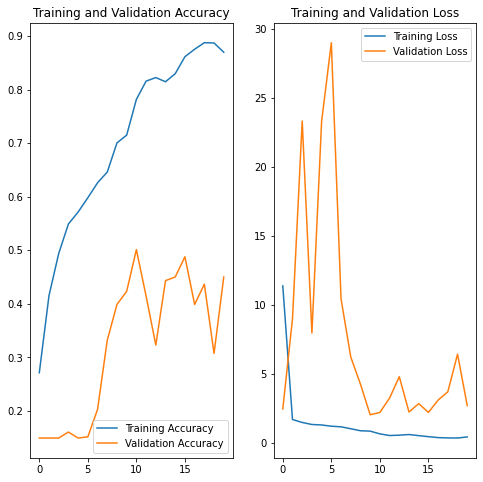

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here


Model 1 (above model) has certainly overfitted, supported by the obvious huge difference between training accuracy and validation accuracy.<br>
It possibly is due to the fact that model has almost memorised the images and may not be able to understand unerlying patterns. <br>
One way to reduce overfitting is to train model with more robust data - using image augmentation. We will try to make model understand underlying patterns in the image and not focus too much on local transformations like rotation/scaling/etc<br>
In next model (Model 2) we will use image augmentation techniques from the Keras library itself and compare Model 1 and Model 2 difference <br>

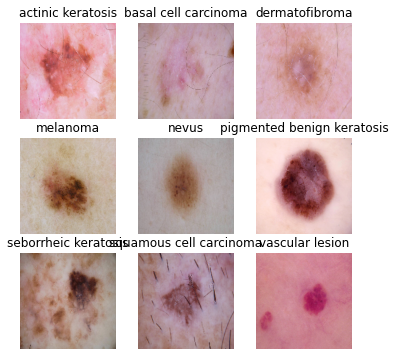

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(6,6))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


Reference links for Image Augmentation using Keras/Tensorflow : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom

In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model2 = Sequential()
model2.add(Rescaling(scale=1./255,input_shape=(180,180,3)))
model2.add(RandomFlip(mode="horizontal_and_vertical", seed=123))
model2.add(RandomRotation(factor=0.3)),
model2.add(RandomZoom(0.2,0.2)) 

model2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.15))

model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.15))

model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.15))

model2.add(Flatten())
model2.add(Dense(8192,activation='relu'))
model2.add(Dropout(0.15))
model2.add(Dense(4096,activation='relu'))
model2.add(Dropout(0.15))
model2.add(Dense(1024,activation='relu'))
model2.add(Dropout(0.15))
model2.add(Dense(512,activation='relu'))
model2.add(Dense(9,activation='softmax'))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                      

### Compiling the model
After we have defined the model, we need to compile the model. During this step, Keras uses the backend libraries to efficiently represent the above-described model for training and prediction. We need to specify the loss function, the metrics as well as the optimiser in this step

In [20]:
## Your code goes here
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Training the model
The next step is to fit the model on the data set available. We also need to pass the number of epochs you want for the training to happen. Essentially, 1 epoch is 1 pass through the entire data set in mini-batches (we will discuss this in the subsequent segments). So, you also need to specify the mini-batch size (the number of data points to be sent through the neural network in one go).

In [21]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=False
)

Epoch 1/20
57/57 [==============================] - 10s 148ms/step - loss: 10.7113 - accuracy: 0.2801 - val_loss: 2.8366 - val_accuracy: 0.1670
Epoch 2/20
57/57 [==============================] - 8s 149ms/step - loss: 1.8129 - accuracy: 0.3836 - val_loss: 15.0042 - val_accuracy: 0.1849
Epoch 3/20
57/57 [==============================] - 8s 144ms/step - loss: 1.7326 - accuracy: 0.4131 - val_loss: 16.8474 - val_accuracy: 0.1492
Epoch 4/20
57/57 [==============================] - 8s 144ms/step - loss: 1.5824 - accuracy: 0.4465 - val_loss: 20.3821 - val_accuracy: 0.1893
Epoch 5/20
57/57 [==============================] - 8s 144ms/step - loss: 1.5297 - accuracy: 0.4749 - val_loss: 21.2419 - val_accuracy: 0.2027
Epoch 6/20
57/57 [==============================] - 8s 145ms/step - loss: 1.5312 - accuracy: 0.4761 - val_loss: 17.1472 - val_accuracy: 0.2116
Epoch 7/20
57/57 [==============================] - 8s 145ms/step - loss: 1.4516 - accuracy: 0.4978 - val_loss: 20.7804 - val_accuracy: 0.187

### Visualizing the results

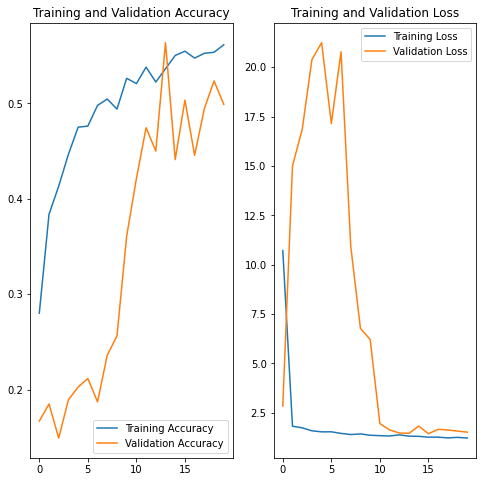

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Comparing results of Model 1 with Model 2(above model) there is certainly an improvement seen - the difference between training accuracy and validation accuracy has gone down drastically.<br>
However, while model is not overfitting, but the accuracy obtained is not satisfactory, hence we will try to do Augmentation using the Augmentor library and then create Model 3 with the augmented data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Total images in actinic keratosis category are 114
Total images in basal cell carcinoma category are 376
Total images in dermatofibroma category are 95
Total images in melanoma category are 438
Total images in nevus category are 363
Total images in pigmented benign keratosis category are 462
Total images in seborrheic keratosis category are 77
Total images in squamous cell carcinoma category are 181
Total images in vascular lesion category are 139


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

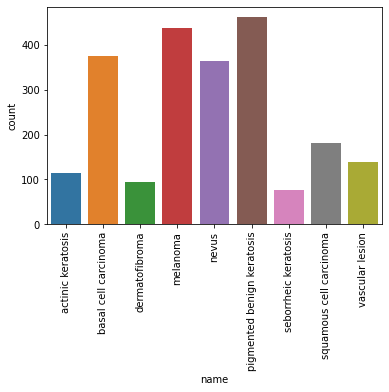

In [23]:
## Your code goes here.
count_dict={}
for c in class_names:
  print("Total images in {} category are {}".format(c,len(os.listdir(str(data_dir_train)+'/'+c))))
  count_dict[c]=len(os.listdir(str(data_dir_train)+'/'+c))

disease_name = list(count_dict.keys())
disease_count = list(count_dict.values())

count_df = pd.DataFrame({'name':disease_name,'count':disease_count})

sns.barplot(x="name",y="count",data=count_df)
plt.xticks(rotation=90)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?




1.   Class "seborrheic keratosis" has the least number of samples, with class "dermatofibroma" and "actinic keratosis" at 2nd and 3rd postion respectively.
2.   Classes like "basal cell carcinoma", "melanoma" , "pigmented benign keratosis" and "nevus" have high number of samples.

As of now, there is huge class imbalance, this explains the fact why validation accuracy might be low in first 2 models - as model had more samples of some classes comapred to others and thus leant more about certain classes compared to others. <br> 

The sample percentage difference between images of 2 classes is very high. <br>
Using Augmentor library we will create 1000 augmented images for each class.<br>
WHile this will not bring count of images for each class as same, it will definitely reduce the sample percentage difference between images between 2 classes. 




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
#path_to_training_dataset=pathlib.Path("/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
#path=pathlib.Path(str(data_dir_train)+'/')

import Augmentor
for i in class_names:
    path_to_training_dataset=pathlib.Path(str(data_dir_train)+'/'+i)
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61120A7E50>: 100%|██████████| 1000/1000 [00:19<00:00, 50.62 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F611208F490>: 100%|██████████| 1000/1000 [00:21<00:00, 46.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F611211F390>: 100%|██████████| 1000/1000 [00:20<00:00, 48.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F6113EEA790>: 100%|██████████| 1000/1000 [01:35<00:00, 10.49 Samples/s]


Initialised with 363 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F6113C8F690>: 100%|██████████| 1000/1000 [01:27<00:00, 11.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F600EF3C0D0>: 100%|██████████| 1000/1000 [00:18<00:00, 53.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F600EF07C90>: 100%|██████████| 1000/1000 [00:41<00:00, 24.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F600EDEEAD0>: 100%|██████████| 1000/1000 [00:18<00:00, 52.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F600EF3C3D0>: 100%|██████████| 1000/1000 [00:18<00:00, 52.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]

['/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026282.jpg_abb9a528-df96-4b1b-8f31-6030a201e45c.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025731.jpg_bd6924b7-e05d-4bff-8273-b51a53a71a4f.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025752.jpg_b1215a33-a88c-4938-b34c-d7f10ec03bf5.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028095.jpg_36a40b13-123c-4b41-bfd4-54524649eb51.jpg',
 '/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma']

In [29]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2
new_df.head(2)

,Path,Label
0,/content/drive/My Drive/Skin cancer ISIC The I...,basal cell carcinoma
1,/content/drive/My Drive/Skin cancer ISIC The I...,basal cell carcinoma


In [31]:
new_df['Label'].value_counts()

basal cell carcinoma          1000
dermatofibroma                1000
nevus                         1000
melanoma                      1000
pigmented benign keratosis    1000
squamous cell carcinoma       1000
vascular lesion               1000
actinic keratosis             1000
seborrheic keratosis          1000
Name: Label, dtype: int64

After Augmentation : Total images in actinic keratosis category are 1115
After Augmentation : Total images in basal cell carcinoma category are 1377
After Augmentation : Total images in dermatofibroma category are 1096
After Augmentation : Total images in melanoma category are 1439
After Augmentation : Total images in nevus category are 1364
After Augmentation : Total images in pigmented benign keratosis category are 1463
After Augmentation : Total images in seborrheic keratosis category are 1078
After Augmentation : Total images in squamous cell carcinoma category are 1182
After Augmentation : Total images in vascular lesion category are 1140


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

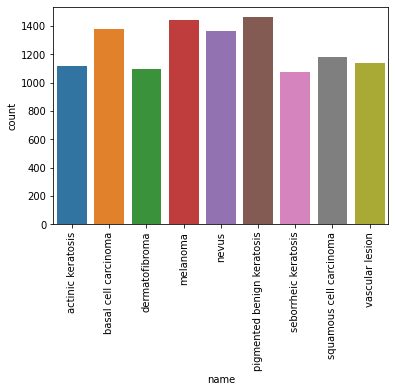

In [32]:
count_dict_post_aug={}
for c in class_names:
  sum=len(os.listdir(str(data_dir_train)+'/'+c))+len(os.listdir(str(data_dir_train)+'/'+c+'/output/'))
  print("After Augmentation : Total images in {} category are {}".format(c,sum))
  count_dict_post_aug[c]=sum

disease_name_aug = list(count_dict_post_aug.keys())
disease_count_aug = list(count_dict_post_aug.values())

count_df_aug = pd.DataFrame({'name':disease_name_aug,'count':disease_count_aug})

sns.barplot(x="name",y="count",data=count_df_aug)
plt.xticks(rotation=90)

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train="/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 9 classes.
Using 8996 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 9 classes.
Using 2249 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## your code goes here
model3 = Sequential()
model3.add(Rescaling(scale=1./255,input_shape=(180,180,3)))
#model3.add(RandomFlip(mode="horizontal_and_vertical", seed=123))
#model3.add(RandomRotation(factor=0.2)),
#model3.add(RandomZoom(0.1,0.1)) 

model3.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.15))

model3.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.15))

model3.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.15))

model3.add(Flatten())
model3.add(Dense(8192,activation='relu'))
model3.add(Dropout(0.15))
model3.add(Dense(4096,activation='relu'))
model3.add(Dropout(0.15))
model3.add(Dense(1024,activation='relu'))
model3.add(Dropout(0.15))
model3.add(Dense(512,activation='relu'))
model3.add(Dense(9,activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 176, 176, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 32)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
## your code goes here
model3.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=False
)

Epoch 1/30
282/282 [==============================] - 72s 158ms/step - loss: 3.7770 - accuracy: 0.4006 - val_loss: 3.3350 - val_accuracy: 0.1912
Epoch 2/30
282/282 [==============================] - 39s 139ms/step - loss: 1.1845 - accuracy: 0.5796 - val_loss: 2.0597 - val_accuracy: 0.3664
Epoch 3/30
282/282 [==============================] - 40s 141ms/step - loss: 0.8538 - accuracy: 0.6999 - val_loss: 0.8054 - val_accuracy: 0.7154
Epoch 4/30
282/282 [==============================] - 40s 142ms/step - loss: 0.6553 - accuracy: 0.7678 - val_loss: 0.9614 - val_accuracy: 0.7043
Epoch 5/30
282/282 [==============================] - 40s 142ms/step - loss: 0.5268 - accuracy: 0.8159 - val_loss: 0.8812 - val_accuracy: 0.7048
Epoch 6/30
282/282 [==============================] - 40s 143ms/step - loss: 0.4071 - accuracy: 0.8590 - val_loss: 1.7464 - val_accuracy: 0.5967
Epoch 7/30
282/282 [==============================] - 41s 144ms/step - loss: 0.3621 - accuracy: 0.8778 - val_loss: 0.5893 - val_ac

`The text above can be analysed as follows:` 

The text 282/282 indicates the number of batches the training step is running 
through. Since the batch size is 32 and the training data set is of size 8996 (80% of the total  dataset) while the rest 20% is validation dataset.

You can also see the amount of time it is taking for training a single batch, for example, 40s/step.

The text snippets loss and val_loss show the sparse categorical cross-entropy loss (mentioned while compiling the model).

The text snippets accuracy and val_accuracy show the proportion of matches between the predicted class and the actual class. This proportion is calculated on the whole training and validation data sets.

And, after 30 epochs (30 run-throughs of training the whole data set), we can see the validation accuracy reached.

Note: The calculation speed, loss, and accuracy may differ slightly in each runtime as it depends on computational power.

#### **Todo:**  Visualize the model results

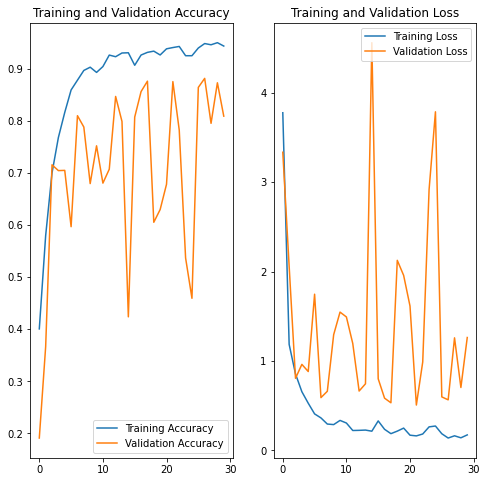

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Model 3 results are certainlt promising and improved compared a lot compared to first 2 models.<br>
Model is overfitting a bit, but considering the time constraint/resource constraints, we have been able to reduce overfitting by hugh margin with the help of Augmenot library.<br>
If we put more time/resources and try out multiple other model layer combinations we can achieve even better results/accuracy. So class rebalalnce has certainly helped.<br>